Import Libraries

In [123]:
import pandas as pd
import numpy as np
import json
import gzip


import nltk
import re
import string
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import sklearn
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn import preprocessing


#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from collections import defaultdict
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from imblearn.over_sampling import SMOTE

Import the dataset

In [40]:
file_path = '/content/drive/MyDrive/Magisterka/Musical_Instruments.json.gz'

In [41]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

raw_df = getDF(file_path)

In [42]:
raw_df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,90,False,"08 9, 2004",AXHY24HWOF184,0470536454,{'Format:': ' Paperback'},Bendy,Crocheting for Dummies by Karen Manthey & Susa...,Terrific Book for Learning the Art of Crochet,1092009600,NaN
1,4.0,2,True,"04 6, 2017",A29OWR79AM796H,0470536454,{'Format:': ' Hardcover'},Amazon Customer,Very helpful...,Four Stars,1491436800,NaN
2,5.0,NaN,True,"03 14, 2017",AUPWU27A7X5F6,0470536454,{'Format:': ' Paperback'},Amazon Customer,EASY TO UNDERSTAND AND A PROMPT SERVICE TOO,Five Stars,1489449600,NaN
3,4.0,NaN,True,"02 14, 2017",A1N69A47D4JO6K,0470536454,{'Format:': ' Paperback'},Christopher Burnett,My girlfriend use quite often,Four Stars,1487030400,NaN
4,5.0,NaN,True,"01 29, 2017",AHTIQUMVCGBFJ,0470536454,{'Format:': ' Paperback'},Amazon Customer,Arrived as described. Very happy.,Very happy.,1485648000,NaN


In [43]:
raw_df.shape

(1512530, 12)

In [44]:
raw_df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,90,False,"08 9, 2004",AXHY24HWOF184,0470536454,{'Format:': ' Paperback'},Bendy,Crocheting for Dummies by Karen Manthey & Susa...,Terrific Book for Learning the Art of Crochet,1092009600,NaN
1,4.0,2,True,"04 6, 2017",A29OWR79AM796H,0470536454,{'Format:': ' Hardcover'},Amazon Customer,Very helpful...,Four Stars,1491436800,NaN
2,5.0,NaN,True,"03 14, 2017",AUPWU27A7X5F6,0470536454,{'Format:': ' Paperback'},Amazon Customer,EASY TO UNDERSTAND AND A PROMPT SERVICE TOO,Five Stars,1489449600,NaN
3,4.0,NaN,True,"02 14, 2017",A1N69A47D4JO6K,0470536454,{'Format:': ' Paperback'},Christopher Burnett,My girlfriend use quite often,Four Stars,1487030400,NaN
4,5.0,NaN,True,"01 29, 2017",AHTIQUMVCGBFJ,0470536454,{'Format:': ' Paperback'},Amazon Customer,Arrived as described. Very happy.,Very happy.,1485648000,NaN


Preprocessing

* reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
* asin - ID of the product, e.g. 0000013714
* reviewerName - name of the reviewer
* vote - helpful votes of the review
* style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
* reviewText - text of the review
* overall - rating of the product
* summary - summary of the review
* unixReviewTime - time of the review (unix time)
* reviewTime - time of the review (raw)
* image - images that users post after they have received the product


In [45]:
#czas unixowy na datetime
#sprawdzić długość w kolumnie summary, zeby sprawdzic jak długie mogą być tam stringi
#sprawdzić kolumnę summary, bo wygląda jakby ludzie wpisywali tam ile dają gwiazdek
#usunąć reviewerName, gdyż nie jest potrzebna, w dodatku jest to forma anonimizacji danych
#ile zdjęć wrzucają ludzie, którzy wyrażają pozytywne opinie na temat produktu a ile ci ktorzy wyrazaja negatywne czy neutralne
#usunąć kolumnę image

In [46]:
max_length = raw_df['summary'].str.len().max()

print("Maksymalna długość tekstu w kolumnie 'summary':", max_length)

Maksymalna długość tekstu w kolumnie 'summary': 428.0


In [47]:
# Tworzenie wyrażenia regularnego do wyszukania wzorców pasujących do ocen w kolumnie "summary"
pattern = r'\b(One|Two|Three|Four|Five) Stars\b'

# Użycie metody str.contains() do znalezienia wierszy, które pasują do wzorca
matches = raw_df['summary'].str.contains(pattern)

# Wyświetlenie ilości takich przypadków
count_matches = matches.sum()
print("Liczba przypadków, w których 'summary' zawiera ocenę:", count_matches)

<ipython-input-47-0f72892feed5>:5: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



Liczba przypadków, w których 'summary' zawiera ocenę: 359661


In [48]:
# Funkcja do zamiany ocen w 'summary' na NaN w kolumnie 'summary'
def replace_ratings_with_nan(row):
    summary = row['summary']

    # Sprawdź, czy 'summary' jest typu string
    if isinstance(summary, str):
        # Sprawdź, czy 'summary' pasuje do wzorca oceny
        if re.search(pattern, summary):
            row['summary'] = None  # Jeśli tak, ustaw wartość na NaN w kolumnie 'summary'

    return row

# Zastosowanie funkcji do DataFrame
raw_df = raw_df.apply(replace_ratings_with_nan, axis=1)


In [49]:
# Tworzenie wyrażenia regularnego do wyszukania wzorców pasujących do ocen w kolumnie "summary"
pattern = r'\b(One|Two|Three|Four|Five) Stars\b'

# Użycie metody str.contains() do znalezienia wierszy, które pasują do wzorca
matches2 = raw_df['summary'].str.contains(pattern)

# Wyświetlenie ilości takich przypadków
count_matches2 = matches2.sum()
print("Liczba przypadków, w których 'summary' zawiera ocenę:", count_matches2)

<ipython-input-49-e21ec3035ad3>:5: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



Liczba przypadków, w których 'summary' zawiera ocenę: 0


In [50]:
print ("The shape of the  data is (row, column):"+ str(raw_df.shape))
print (raw_df.info())

The shape of the  data is (row, column):(1512530, 12)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1512530 entries, 0 to 1512529
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         1512530 non-null  float64
 1   vote            243948 non-null   object 
 2   verified        1512530 non-null  bool   
 3   reviewTime      1512530 non-null  object 
 4   reviewerID      1512530 non-null  object 
 5   asin            1512530 non-null  object 
 6   style           672538 non-null   object 
 7   reviewerName    1512380 non-null  object 
 8   reviewText      1511675 non-null  object 
 9   summary         1152489 non-null  object 
 10  unixReviewTime  1512530 non-null  int64  
 11  image           30165 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 139.9+ MB
None


In [51]:
print('Percent of summaries containing ratings = ' + str(count_matches2/raw_df.shape[0]*100) + '%')

Percent of summaries containing ratings = 0.0%


In [52]:
raw_df['overall'].value_counts()

5.0    984097
4.0    237295
1.0    118102
3.0    106249
2.0     66787
Name: overall, dtype: int64

In [53]:
raw_df.isnull().sum()

overall                 0
vote              1268582
verified                0
reviewTime              0
reviewerID              0
asin                    0
style              839992
reviewerName          150
reviewText            855
summary            360041
unixReviewTime          0
image             1482365
dtype: int64

In [54]:
#funkcja konwertująca oceny na sentyment
def overall_to_opinion(row):

    '''This function returns sentiment value based on the overall ratings from the user'''

    if row['overall'] == 3.0:
        val = 'Neutral'
    elif row['overall'] < 3.0:
        val = 'Negative'
    elif row['overall'] > 3.0:
        val = 'Positive'
    else:
        val = None
    return val

In [55]:
df = raw_df
df['opinion'] = df.apply(overall_to_opinion, axis=1)
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,opinion
0,5.0,90,False,"08 9, 2004",AXHY24HWOF184,0470536454,{'Format:': ' Paperback'},Bendy,Crocheting for Dummies by Karen Manthey & Susa...,Terrific Book for Learning the Art of Crochet,1092009600,NaN,Positive
1,4.0,2,True,"04 6, 2017",A29OWR79AM796H,0470536454,{'Format:': ' Hardcover'},Amazon Customer,Very helpful...,None,1491436800,NaN,Positive
2,5.0,NaN,True,"03 14, 2017",AUPWU27A7X5F6,0470536454,{'Format:': ' Paperback'},Amazon Customer,EASY TO UNDERSTAND AND A PROMPT SERVICE TOO,None,1489449600,NaN,Positive
3,4.0,NaN,True,"02 14, 2017",A1N69A47D4JO6K,0470536454,{'Format:': ' Paperback'},Christopher Burnett,My girlfriend use quite often,None,1487030400,NaN,Positive
4,5.0,NaN,True,"01 29, 2017",AHTIQUMVCGBFJ,0470536454,{'Format:': ' Paperback'},Amazon Customer,Arrived as described. Very happy.,Very happy.,1485648000,NaN,Positive


In [56]:
print(df['opinion'].isnull().sum())

0


In [57]:
# Obliczenie liczby recenzji ze zdjęciami dla każdej oceny 'overall'
image_counts = df[df['image'].notnull()]['overall'].value_counts().sort_index().reset_index()
image_counts.columns = ['overall', 'reviews_with_images']

# Obliczenie liczby wszystkich recenzji dla każdej oceny 'overall'
total_counts = df['overall'].value_counts().sort_index().reset_index()
total_counts.columns = ['overall', 'total_reviews']

# Połączenie obu zestawień danych
merged_df = pd.merge(total_counts, image_counts, on='overall', how='left')

# Obliczenie stosunku i przekształcenie go na wartość procentową
merged_df['percent_with_images'] = (merged_df['reviews_with_images'] / merged_df['total_reviews']) * 100

print(merged_df)

   overall  total_reviews  reviews_with_images  percent_with_images
0      1.0         118102                 4124             3.491897
1      2.0          66787                 1638             2.452573
2      3.0         106249                 2006             1.888018
3      4.0         237295                 4161             1.753514
4      5.0         984097                18236             1.853069


In [58]:
# Obliczenie liczby recenzji ze zdjęciami dla każdej oceny 'overall'
image_counts = df[df['image'].notnull()]['opinion'].value_counts().sort_index().reset_index()
image_counts.columns = ['opinion', 'reviews_with_images']

# Obliczenie liczby wszystkich recenzji dla każdej oceny 'overall'
total_counts = df['opinion'].value_counts().sort_index().reset_index()
total_counts.columns = ['opinion', 'total_reviews']

# Połączenie obu zestawień danych
merged_df = pd.merge(total_counts, image_counts, on='opinion', how='left')

# Obliczenie stosunku i przekształcenie go na wartość procentową
merged_df['percent_with_images'] = (merged_df['reviews_with_images'] / merged_df['total_reviews']) * 100

print(merged_df)

    opinion  total_reviews  reviews_with_images  percent_with_images
0  Negative         184889                 5762             3.116464
1   Neutral         106249                 2006             1.888018
2  Positive        1221392                22397             1.833727


In [59]:
null_counts = df.isnull().sum()
print(null_counts)

overall                 0
vote              1268582
verified                0
reviewTime              0
reviewerID              0
asin                    0
style              839992
reviewerName          150
reviewText            855
summary            360041
unixReviewTime          0
image             1482365
opinion                 0
dtype: int64


In [60]:
df.dropna(subset=['reviewText'], inplace=True)

In [61]:
null_counts = df.isnull().sum()
print(null_counts)

overall                 0
vote              1267814
verified                0
reviewTime              0
reviewerID              0
asin                    0
style              839561
reviewerName          149
reviewText              0
summary            359324
unixReviewTime          0
image             1481780
opinion                 0
dtype: int64


In [62]:
print ("The shape of the  data is (row, column):"+ str(df.shape))
print (df.info())

The shape of the  data is (row, column):(1511675, 13)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1511675 entries, 0 to 1512529
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         1511675 non-null  float64
 1   vote            243861 non-null   object 
 2   verified        1511675 non-null  bool   
 3   reviewTime      1511675 non-null  object 
 4   reviewerID      1511675 non-null  object 
 5   asin            1511675 non-null  object 
 6   style           672114 non-null   object 
 7   reviewerName    1511526 non-null  object 
 8   reviewText      1511675 non-null  object 
 9   summary         1152351 non-null  object 
 10  unixReviewTime  1511675 non-null  int64  
 11  image           29895 non-null    object 
 12  opinion         1511675 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(10)
memory usage: 151.4+ MB
None


In [63]:
# Konwertuj kolumnę 'vote' na typ danych float, zamieniając NaN na 0
df['vote'] = pd.to_numeric(df['vote'], errors='coerce').fillna(0)

Ile było głosów "przydatności" w opiniach pozytywnych, neutralnych i negatywnych?

In [64]:
vote_sum_by_sentiment = df.groupby('opinion')['vote'].sum()

# Wyświetlenie wyników
print(vote_sum_by_sentiment)

opinion
Negative     253821.0
Neutral      128976.0
Positive    1229001.0
Name: vote, dtype: float64


In [65]:
# Grupowanie danych według kolumny 'verified' i sentymentu 'sentiment' oraz obliczenie liczności
opinion_by_verified = df.groupby(['verified', 'opinion']).size().unstack(fill_value=0)


print(opinion_by_verified)


opinion   Negative  Neutral  Positive
verified                             
False        27571    12313    126452
True        157263    93911   1094165


In [66]:
# Zakładając, że masz już wczytany DataFrame 'df'

# Grupowanie danych według kolumny 'verified' i sentymentu 'sentiment' oraz obliczenie liczności
sentiment_by_verified = df.groupby(['opinion', 'verified']).size().unstack(fill_value=0)


print(sentiment_by_verified)


verified   False    True 
opinion                  
Negative   27571   157263
Neutral    12313    93911
Positive  126452  1094165


Jaki stosunek poszczególnych opinii stanowią opinie zweryfikowane?

In [67]:
# Grupowanie danych według sentymentu 'sentiment' i obliczenie procentu 'True' w kolumnie 'verified'
percentage_verified_by_opinion = df.groupby('opinion')['verified'].mean() * 100


print(percentage_verified_by_opinion)


opinion
Negative    85.083372
Neutral     88.408458
Positive    89.640321
Name: verified, dtype: float64


In [68]:
df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s')


print(df.head(10))

   overall  vote  verified   reviewTime      reviewerID        asin  \
0      5.0  90.0     False   08 9, 2004   AXHY24HWOF184  0470536454   
1      4.0   2.0      True   04 6, 2017  A29OWR79AM796H  0470536454   
2      5.0   0.0      True  03 14, 2017   AUPWU27A7X5F6  0470536454   
3      4.0   0.0      True  02 14, 2017  A1N69A47D4JO6K  0470536454   
4      5.0   0.0      True  01 29, 2017   AHTIQUMVCGBFJ  0470536454   
5      5.0   0.0      True   01 4, 2017  A1J8LQ7HVLR9GU  0470536454   
6      5.0   0.0      True   01 2, 2017   ABVTZ63S6GOWF  0470536454   
7      4.0   0.0      True  12 21, 2016  A2HX9NFBXGSWRW  0470536454   
8      4.0   0.0      True  12 20, 2016   AP1TQR64HQRCI  0470536454   
9      5.0   0.0      True  12 15, 2016   A37FC9MED20AO  0470536454   

                            style         reviewerName  \
0       {'Format:': ' Paperback'}                Bendy   
1       {'Format:': ' Hardcover'}      Amazon Customer   
2       {'Format:': ' Paperback'}      Amazo

Dalszy preprocessing
Usunięcie zbędnych kolumn

<Figure size 1000x600 with 0 Axes>

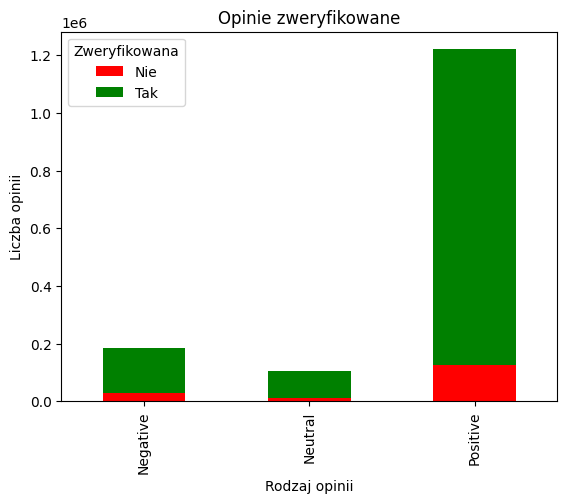

In [69]:
plt.figure(figsize=(10, 6))  # Rozmiar wykresu
sentiment_by_verified.plot(kind='bar', stacked=True, color=['red', 'green'])  # Wykres grupowany i kolory
plt.title('Opinie zweryfikowane')  # Tytuł wykresu
plt.xlabel('Rodzaj opinii')  # Etykieta osi X
plt.ylabel('Liczba opinii')  # Etykieta osi Y

# Dodanie legendy
plt.legend(title='Zweryfikowana', labels=['Nie', 'Tak'])


plt.show()

<Figure size 1000x600 with 0 Axes>

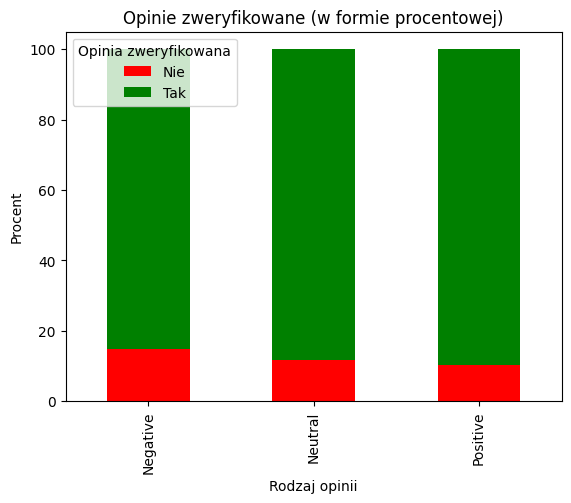

In [70]:
# Obliczenie sumy dla każdej kategorii sentymentu
total_sentiment = sentiment_by_verified.sum(axis=1)

# Obliczenie procentowego udziału każdej kategorii sentymentu
percentage_sentiment_by_verified = sentiment_by_verified.divide(total_sentiment, axis=0) * 100

# Tworzenie wykresu grupowanego w formie procentowej
plt.figure(figsize=(10, 6))  # Rozmiar wykresu
percentage_sentiment_by_verified.plot(kind='bar', stacked=True, color=['red', 'green'])  # Wykres grupowany i kolory
plt.title('Opinie zweryfikowane (w formie procentowej)')  # Tytuł wykresu
plt.xlabel('Rodzaj opinii')  # Etykieta osi X
plt.ylabel('Procent')  # Etykieta osi Y

# Dodanie legendy
plt.legend(title='Opinia zweryfikowana', labels=['Nie', 'Tak'], loc='upper left')


plt.show()


In [71]:
#kolumny do usunięcia
#vote, verified, reviewerID, asin, style, reviewerName, summary, image

In [72]:
df['summary'].fillna('', inplace=True)
df['review'] = df['reviewText'] + df['summary']
#zamiana czasu unix na datetime
df['reviewDate'] = pd.to_datetime(df['unixReviewTime'], unit='s')
columns_to_remove = ['vote', 'verified', 'reviewerID', 'asin', 'style', 'reviewerName', 'image', 'reviewTime', 'overall', 'reviewText', 'summary', 'unixReviewTime']

# Usunięcie wskazanych kolumn
data = df.drop(columns=columns_to_remove)
data.head()

,opinion,review,reviewDate
0,Positive,Crocheting for Dummies by Karen Manthey & Susa...,2004-08-09
1,Positive,Very helpful...,2017-04-06
2,Positive,EASY TO UNDERSTAND AND A PROMPT SERVICE TOO,2017-03-14
3,Positive,My girlfriend use quite often,2017-02-14
4,Positive,Arrived as described. Very happy.Very happy.,2017-01-29


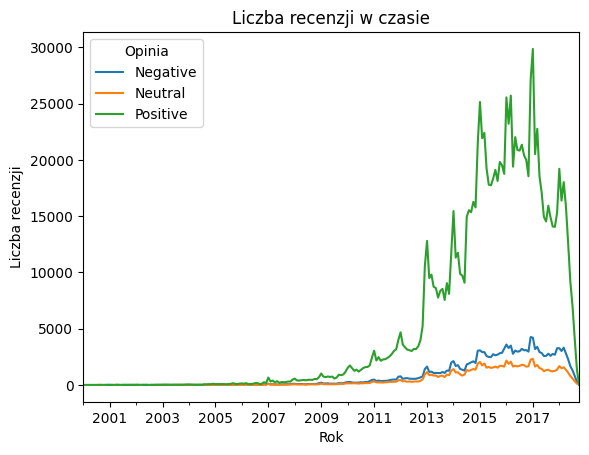

In [75]:
# Grupowanie danych według miesiąca i sentymentu, a następnie obliczenie liczności
monthly_sentiment_count = data.groupby([data['reviewDate'].dt.to_period('M'), 'opinion'])['opinion'].count().unstack()

# Tworzenie wykresu
monthly_sentiment_count.plot(legend=True)
plt.title('Liczba recenzji w czasie')
plt.xlabel('Rok')
plt.ylabel('Liczba recenzji')
plt.legend(title='Opinia')
plt.show()

In [76]:
def review_cleaning(text):
    text = str(text).lower() #lowercase
    text = re.sub('\[.*?\]', '', text) #removing text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) #removing links
    #removing punctuation
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text) #removing words containg numbers
    return text

In [101]:
sampled_data = data.sample(frac = 0.1, random_state = 42)
clean_data = sampled_data
clean_data['review'] = clean_data['review'].apply(lambda x:review_cleaning(x))
clean_data.head()

,opinion,review,reviewDate
442654,Positive,i purchased this for my year old grandson for...,2011-01-28
210965,Positive,exactly as described made in germany the bmw o...,2015-01-08
1498180,Positive,all four work with no broken connectors or dea...,2016-06-04
1426256,Positive,never seen anything like these before i got o...,2018-08-05
456022,Positive,i ordered this cover for my daughter she was ...,2010-08-30


In [102]:
clean_data.shape

(151168, 3)

In [103]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each',
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above',
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't",
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from',
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs',
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [104]:
clean_data['review'] = clean_data['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
clean_data.head()

,opinion,review,reviewDate
442654,Positive,purchased year old grandson christmas loves li...,2011-01-28
210965,Positive,exactly described made germany bmw strap locks,2015-01-08
1498180,Positive,four work no broken connectors dead spots grea...,2016-06-04
1426256,Positive,never seen anything like got one set colorway ...,2018-08-05
456022,Positive,ordered cover daughter using older flute hard ...,2010-08-30


In [ ]:
data_for_word_review_counts = clean_data.copy()
data_for_word_review_counts['review_len'] = data_for_word_review_counts['review'].astype(str).apply(len)
data_for_word_review_counts['word_count'] = data_for_word_review_counts['review'].apply(lambda x: len(str(x).split()))

In [ ]:
data_for_word_review_counts.head()

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data_for_word_review_counts['review_len'], bins=50, color='blue', alpha=0.7)
plt.title('Rozkład liczby znaków w recenzji')
plt.xlabel('Liczba znaków w recenzji')
plt.ylabel('Liczba recenzji')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data_for_word_review_counts['word_count'], bins=50, color='green', alpha=0.7)
plt.title('Rozkład liczby słów w recenzji')
plt.xlabel('Liczba słów w recenzji')
plt.ylabel('Liczba recenzji')
plt.grid(True)
plt.show()

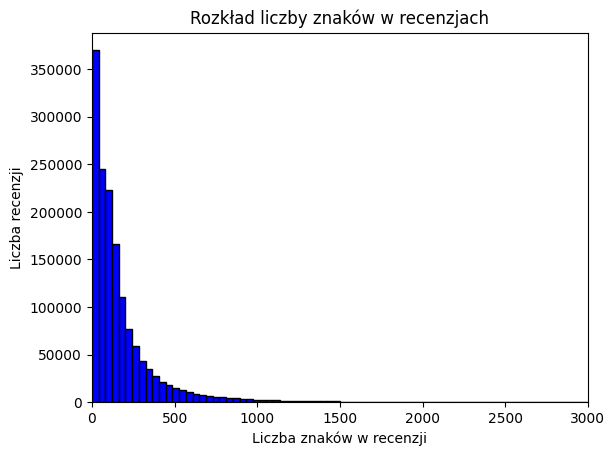

In [42]:
plt.hist(data_for_word_review_counts['review_len'], bins=500, color='blue', edgecolor='black')

# Dodanie tytułów i etykiet osi
plt.xlabel('Liczba znaków w recenzji')
plt.ylabel('Liczba recenzji')
plt.title('Rozkład liczby znaków w recenzjach')
plt.ticklabel_format(style='plain', axis='y')
plt.xlim(0, 3000)
plt.show()

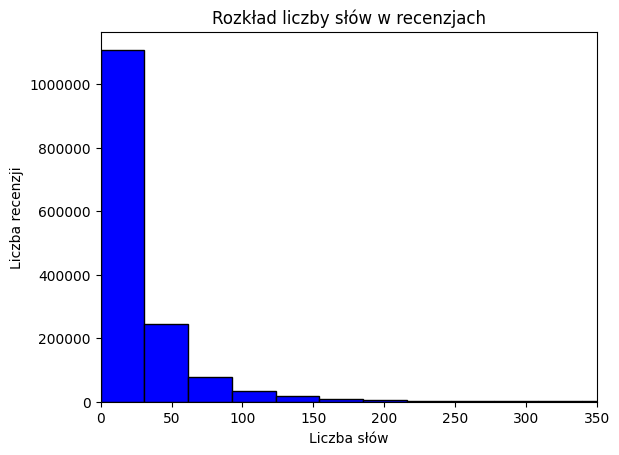

In [43]:
plt.hist(data_for_word_review_counts['word_count'], bins=100, color='blue', edgecolor='black')

# Dodanie tytułów i etykiet osi
plt.xlabel('Liczba słów')
plt.ylabel('Liczba recenzji')
plt.title('Rozkład liczby słów w recenzjach')
plt.ticklabel_format(style='plain', axis='y')
plt.xlim(0, 350)
plt.xticks(range(0,351,50))
plt.show()

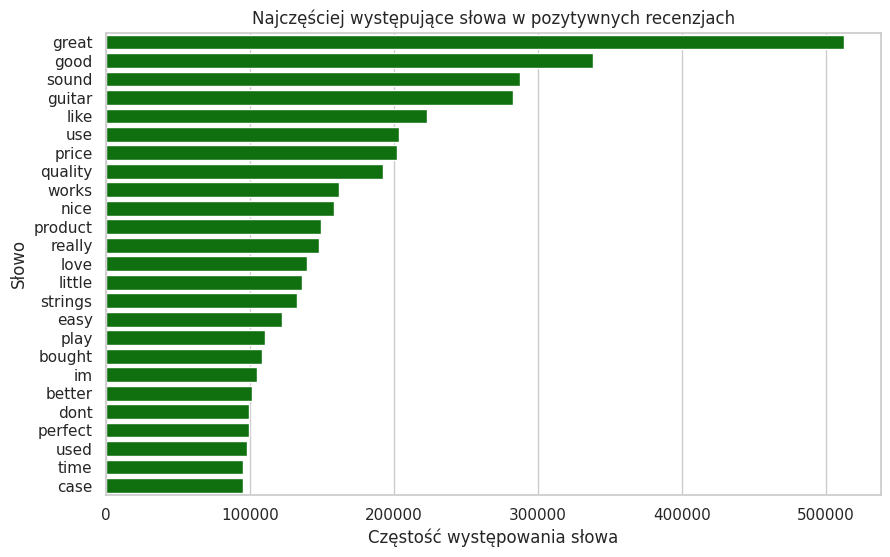

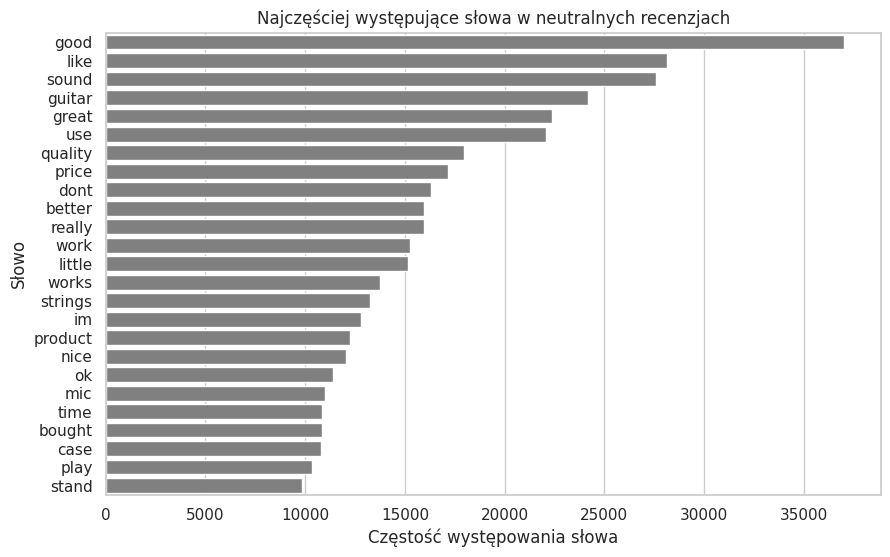

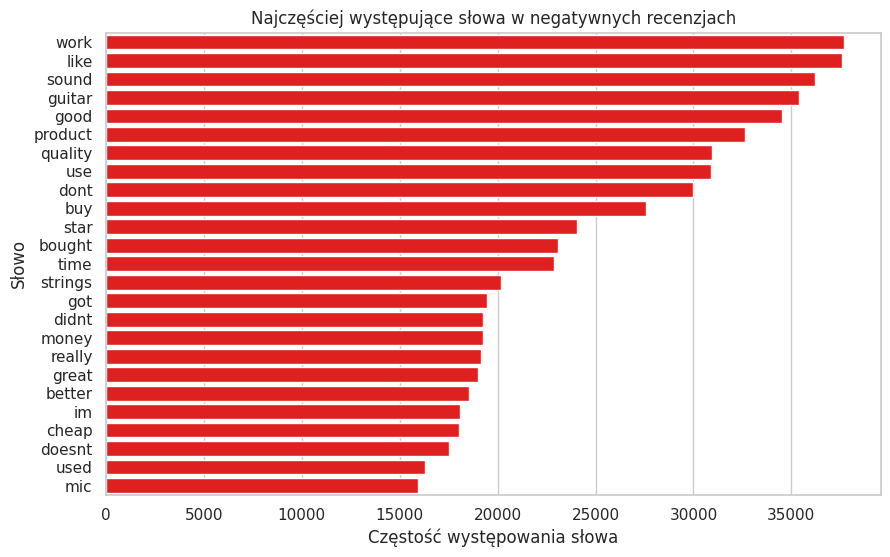

In [44]:
# Define your custom function for ngram generation
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in ENGLISH_STOP_WORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# Define your custom function for horizontal bar chart
def horizontal_bar_chart(df, color, title):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="wordcount", y="word", data=df, color = color)
    ax.set_title(title)
    ax.set_xlabel("Częstość występowania słowa")
    ax.set_ylabel("Słowo")
    plt.show()

# Filter and process your data
review_pos = clean_data[clean_data["opinion"] == 'Positive'].dropna()
review_neu = clean_data[clean_data["opinion"] == 'Neutral'].dropna()
review_neg = clean_data[clean_data["opinion"] == 'Negative'].dropna()

# Get the bar chart from positive reviews
freq_dict = defaultdict(int)
for sent in review_pos["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25], columns=["word", "wordcount"])
horizontal_bar_chart(fd_sorted, 'green', 'Najczęściej występujące słowa w pozytywnych recenzjach')

# Get the bar chart from neutral reviews
freq_dict = defaultdict(int)
for sent in review_neu["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25], columns=["word", "wordcount"])
horizontal_bar_chart(fd_sorted, 'grey', 'Najczęściej występujące słowa w neutralnych recenzjach')

# Get the bar chart from negative reviews
freq_dict = defaultdict(int)
for sent in review_neg["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25], columns=["word", "wordcount"])
horizontal_bar_chart(fd_sorted, 'red', 'Najczęściej występujące słowa w negatywnych recenzjach')


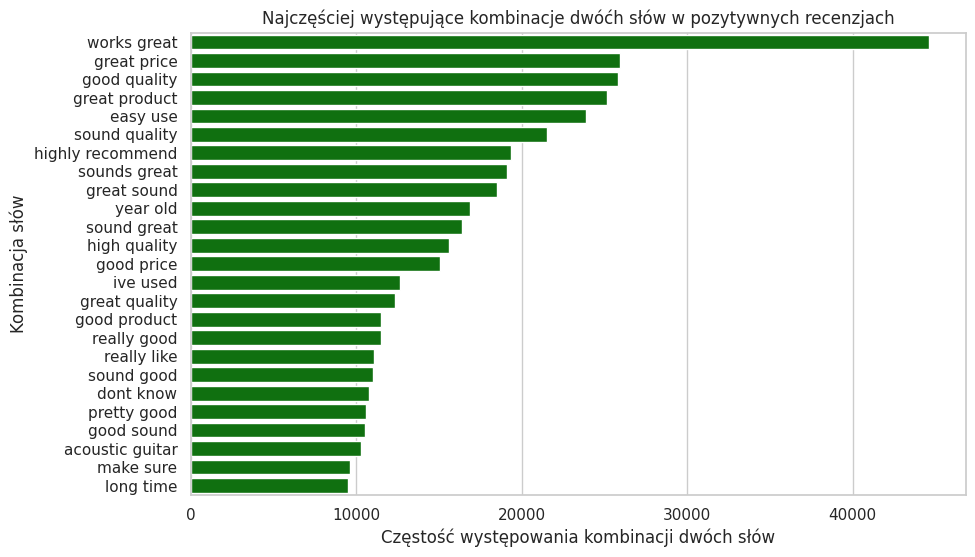

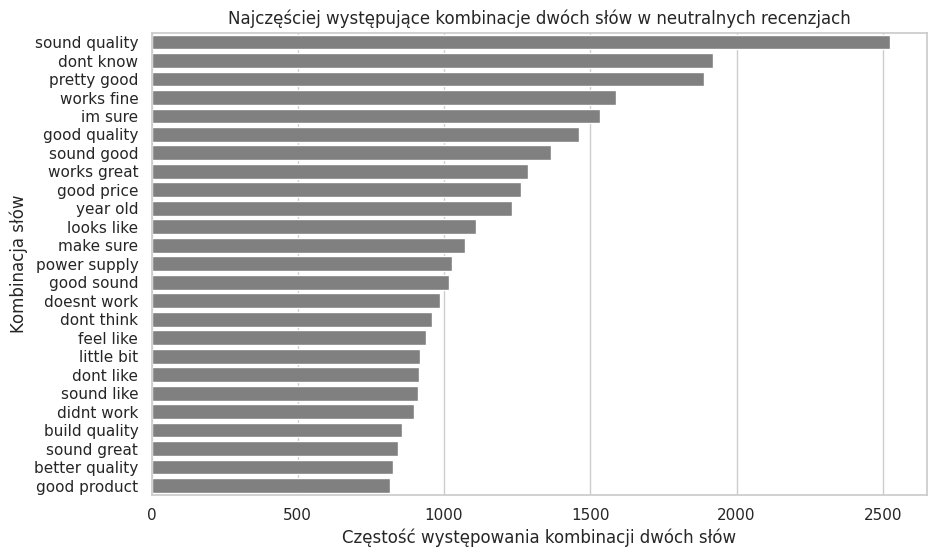

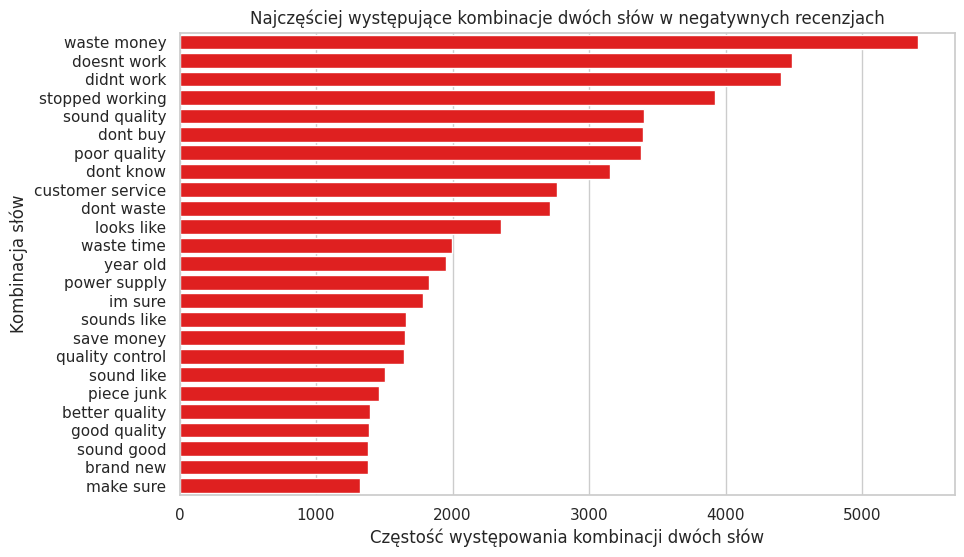

In [45]:
# Define your custom function for ngram generation
def generate_ngrams(text, n_gram=2):
    token = [token for token in text.lower().split(" ") if token != "" if token not in ENGLISH_STOP_WORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# Define your custom function for horizontal bar chart
def horizontal_bar_chart(df, color, title):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="wordcount", y="word", data=df, color = color)
    ax.set_title(title)
    ax.set_xlabel("Częstość występowania kombinacji dwóch słów")
    ax.set_ylabel("Kombinacja słów")
    plt.show()

# Filter and process your data
review_pos = clean_data[clean_data["opinion"] == 'Positive'].dropna()
review_neu = clean_data[clean_data["opinion"] == 'Neutral'].dropna()
review_neg = clean_data[clean_data["opinion"] == 'Negative'].dropna()

# Get the bar chart from positive reviews
freq_dict = defaultdict(int)
for sent in review_pos["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25], columns=["word", "wordcount"])
horizontal_bar_chart(fd_sorted, 'green', 'Najczęściej występujące kombinacje dwóćh słów w pozytywnych recenzjach')

# Get the bar chart from neutral reviews
freq_dict = defaultdict(int)
for sent in review_neu["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25], columns=["word", "wordcount"])
horizontal_bar_chart(fd_sorted, 'grey', 'Najczęściej występujące kombinacje dwóch słów w neutralnych recenzjach')

# Get the bar chart from negative reviews
freq_dict = defaultdict(int)
for sent in review_neg["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25], columns=["word", "wordcount"])
horizontal_bar_chart(fd_sorted, 'red', 'Najczęściej występujące kombinacje dwóch słów w negatywnych recenzjach')


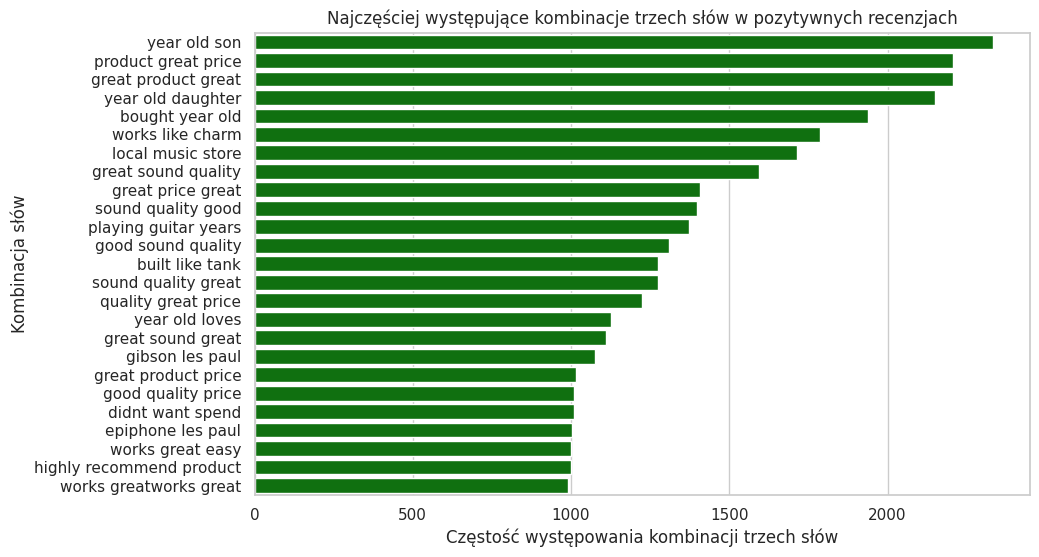

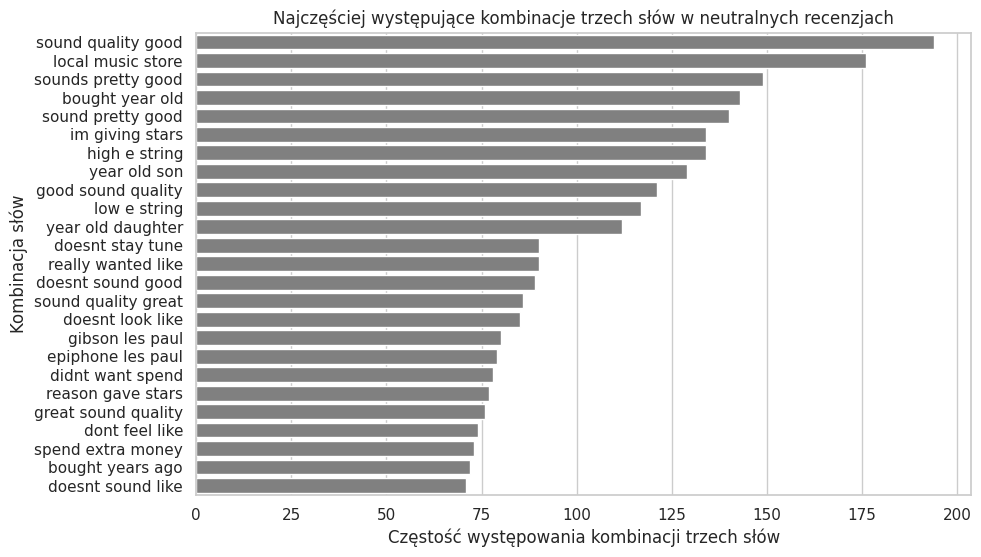

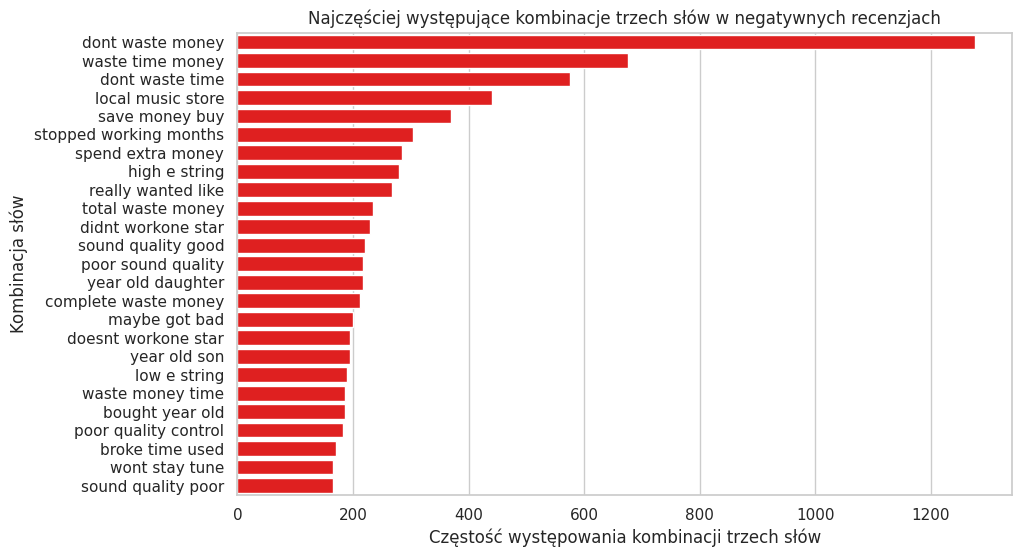

In [46]:
# Define your custom function for ngram generation
def generate_ngrams(text, n_gram=3):
    token = [token for token in text.lower().split(" ") if token != "" if token not in ENGLISH_STOP_WORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# Define your custom function for horizontal bar chart
def horizontal_bar_chart(df, color, title):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="wordcount", y="word", data=df, color = color)
    ax.set_title(title)
    ax.set_xlabel("Częstość występowania kombinacji trzech słów")
    ax.set_ylabel("Kombinacja słów")
    plt.show()

# Filter and process your data
review_pos = clean_data[clean_data["opinion"] == 'Positive'].dropna()
review_neu = clean_data[clean_data["opinion"] == 'Neutral'].dropna()
review_neg = clean_data[clean_data["opinion"] == 'Negative'].dropna()

# Get the bar chart from positive reviews
freq_dict = defaultdict(int)
for sent in review_pos["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25], columns=["word", "wordcount"])
horizontal_bar_chart(fd_sorted, 'green', 'Najczęściej występujące kombinacje trzech słów w pozytywnych recenzjach')

# Get the bar chart from neutral reviews
freq_dict = defaultdict(int)
for sent in review_neu["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25], columns=["word", "wordcount"])
horizontal_bar_chart(fd_sorted, 'grey', 'Najczęściej występujące kombinacje trzech słów w neutralnych recenzjach')

# Get the bar chart from negative reviews
freq_dict = defaultdict(int)
for sent in review_neg["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25], columns=["word", "wordcount"])
horizontal_bar_chart(fd_sorted, 'red', 'Najczęściej występujące kombinacje trzech słów w negatywnych recenzjach')


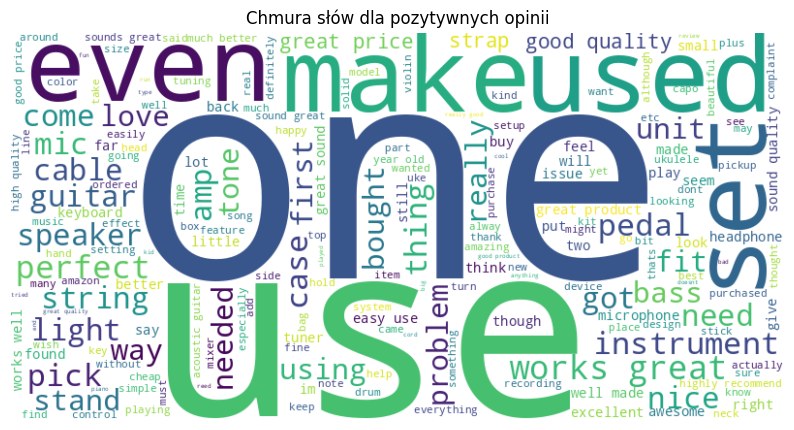

In [17]:
# Wybierz tylko 20% pozytywnych recenzji
positive_reviews = clean_data[clean_data['opinion'] == 'Positive']['review']

positive_reviews_sample = positive_reviews.sample(frac=0.2, random_state=42)

# Tworzenie tekstu z recenzji pozytywnych
text = ' '.join(positive_reviews_sample)

# Tworzenie WordCloud z mniejszym rozmiarem
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Wyświetlenie WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Chmura słów dla pozytywnych opinii')
plt.show()

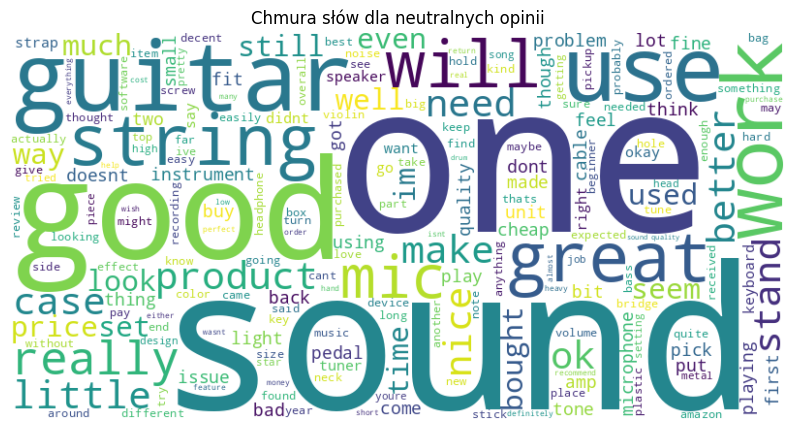

In [19]:
# Wybierz tylko 20% pozytywnych recenzji
neutral_reviews = clean_data[clean_data['opinion'] == 'Neutral']['review']

neutral_reviews_sample = neutral_reviews.sample(frac=0.2, random_state=42)

# Tworzenie tekstu z recenzji pozytywnych
text = ' '.join(neutral_reviews_sample)

# Tworzenie WordCloud z mniejszym rozmiarem
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Wyświetlenie WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Chmura słów dla neutralnych opinii')
plt.show()

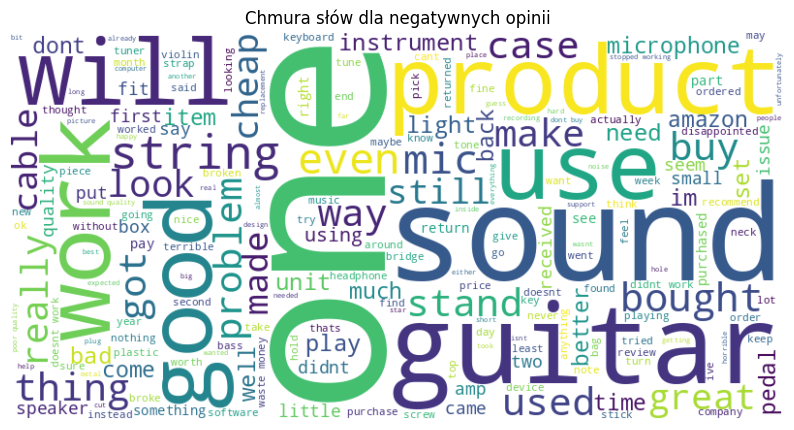

In [20]:
# Wybierz tylko 20% pozytywnych recenzji
negative_reviews = clean_data[clean_data['opinion'] == 'Negative']['review']

negative_reviews_sample = negative_reviews.sample(frac=0.2, random_state=42)

# Tworzenie tekstu z recenzji pozytywnych
text = ' '.join(negative_reviews_sample)

# Tworzenie WordCloud z mniejszym rozmiarem
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Wyświetlenie WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Chmura słów dla negatywnych opinii')
plt.show()

In [105]:
# calling the label encoder function
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'sentiment'.
clean_data['opinion_encoded']= label_encoder.fit_transform(clean_data['opinion'])

clean_data['opinion_encoded']

442654     2
210965     2
1498180    2
1426256    2
456022     2
          ..
1335904    2
1013128    2
1188290    2
1222658    2
1286708    2
Name: opinion_encoded, Length: 151168, dtype: int64

In [106]:
clean_data['opinion'].unique()

array(['Positive', 'Negative', 'Neutral'], dtype=object)

In [107]:
clean_data['opinion'].value_counts()

Positive    121919
Negative     18608
Neutral      10641
Name: opinion, dtype: int64

In [109]:
clean_data[clean_data['opinion'] == 'Neutral']

,opinion,review,reviewDate,opinion_encoded
665587,Neutral,ive used year tensioning screw connects shock ...,2017-07-13,1
766617,Neutral,smell really bad didnt get good variety black ...,2016-09-09,1
1142559,Neutral,not concert wasnt worth buying normanmcpherson,2015-05-31,1
43871,Neutral,tried since like easy playing action but guita...,2012-10-13,1
422369,Neutral,nice loud bell great ski races bought bunch cr...,2016-12-15,1
...,...,...,...,...
824409,Neutral,complaining silly stand job could improved loc...,2018-02-10,1
478438,Neutral,smaller thought ok starterjr drums,2015-09-09,1
184281,Neutral,not expect best materials given price but desi...,2016-05-15,1
764135,Neutral,liked first days rubber pad screw fell off hop...,2018-01-02,1


In [110]:
# Wybierz dane dla każdej klasy
positive_samples = clean_data[clean_data['opinion'] == 'Positive']
neutral_samples = clean_data[clean_data['opinion'] == 'Neutral']
negative_samples = clean_data[clean_data['opinion'] == 'Negative']

# Znajdź minimalną liczbę próbek w każdej klasie
min_samples = min(len(positive_samples), len(neutral_samples), len(negative_samples))

In [111]:
len(negative_samples)

18608

In [112]:
print(min_samples)

10641


In [114]:
sampled_positive = clean_data[clean_data['opinion'] == 'Positive'].astype('category').sample(n=10000, random_state=42)
sampled_neutral = clean_data[clean_data['opinion'] == 'Neutral'].astype('category').sample(n=10000, random_state=42)
sampled_negative = clean_data[clean_data['opinion'] == 'Negative'].astype('category').sample(n=10000, random_state=42)

# Połącz wybrane próbki w jednym DataFrame
balanced_data = pd.concat([sampled_positive, sampled_neutral, sampled_negative])
balanced_data['opinion'].value_counts()

Positive    10000
Neutral     10000
Negative    10000
Name: opinion, dtype: int64

In [115]:
features = balanced_data.copy()
features = features[['review']].reset_index(drop=True)
features.head()

,review
0,great quality
1,easy learn play
2,produce daily music mix public radio stations ...
3,best cables ever not professional compare prof...
4,ernie ball regular slinky strings need say


In [116]:
# Zainicjowanie stemmera
stemmer = PorterStemmer()

# Przykładowa kolumna 'reviewText' w DataFrame
features['review'] = features['review'].apply(lambda text: ' '.join([stemmer.stem(word) for word in text.split()]))


In [117]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(features['review'])

In [31]:
X.shape

(1511675, 5000)

In [118]:
y=balanced_data['opinion_encoded']

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
# Naive Bayes
nb = MultinomialNB()

# Model
nb_model = nb.fit(X_train, y_train)

# Predict
nb_predict = nb.predict(X_test)

# Accuracy
nb_acc = accuracy_score(y_test,nb_predict)

print('nb test accuracy:', nb_acc)

nb test accuracy: 0.6166666666666667


In [127]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest
rf = RandomForestClassifier()

# Model
rf_model = rf.fit(X_train, y_train)

# Predict
rf_predict = rf.predict(X_test)

# Accuracy
rf_acc = accuracy_score(y_test,rf_predict)

print('rf test accuracy:', rf_acc)

rf test accuracy: 0.6098333333333333


In [128]:
# SVC
svc = SVC()

# Model
svc_model = svc.fit(X_train, y_train)

# Predict
svc_predict = svc.predict(X_test)

# Accuracy
svc_acc = accuracy_score(y_test,svc_predict)

print('svc test accuracy:', svc_acc)

svc test accuracy: 0.6338333333333334


In [129]:
knn = KNeighborsClassifier()

# Model
knn_model = knn.fit(X_train, y_train)

# Predict
knn_predict = knn.predict(X_test)

# Accuracy
knn_acc = accuracy_score(y_test,knn_predict)

print('knn test accuracy:', knn_acc)

knn test accuracy: 0.42966666666666664


In [133]:
print(classification_report(y_test, nb_predict))

              precision    recall  f1-score   support

           0       0.70      0.61      0.65      2002
           1       0.49      0.63      0.55      1996
           2       0.72      0.61      0.66      2002

    accuracy                           0.62      6000
   macro avg       0.64      0.62      0.62      6000
weighted avg       0.64      0.62      0.62      6000



In [135]:
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

           0       0.66      0.57      0.62      2002
           1       0.56      0.48      0.52      1996
           2       0.61      0.77      0.68      2002

    accuracy                           0.61      6000
   macro avg       0.61      0.61      0.60      6000
weighted avg       0.61      0.61      0.60      6000



In [134]:
print(classification_report(y_test, svc_predict))

              precision    recall  f1-score   support

           0       0.70      0.59      0.64      2002
           1       0.55      0.57      0.56      1996
           2       0.66      0.74      0.70      2002

    accuracy                           0.63      6000
   macro avg       0.64      0.63      0.63      6000
weighted avg       0.64      0.63      0.63      6000



In [136]:
print(classification_report(y_test, knn_predict))

              precision    recall  f1-score   support

           0       0.50      0.36      0.41      2002
           1       0.49      0.09      0.15      1996
           2       0.40      0.84      0.54      2002

    accuracy                           0.43      6000
   macro avg       0.46      0.43      0.37      6000
weighted avg       0.46      0.43      0.37      6000

